# Denoising Diffusion Probabilistic Models V3 with tinyai

a quick setup for running tinyia in cloud.\
torchaudio return a error idk why.

In [ ]:
! git clone https://github.com/GalaxUniv/tinyai.git
! pip install -e tinyai/.
! pip uninstall torchaudio

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

# Setup

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *
from tinyai.sgd import *
from tinyai.resnet import *
from tinyai.augment import *
from tinyai.accel import *

In [ ]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=2

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)

In [ ]:
from types import SimpleNamespace

Same as in the notebook 21_cifar10 (it was covered before this one) \
SimpleNamespace allows us to create an object with attributes from a dictionary.

In [ ]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [ ]:
def abar(t, T): return (t/T*math.pi/2).cos()**2

Cosine Noise Scheduler Implementation

In [ ]:
def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts,n_steps)
    alp = ab/abar(ts-1,n_steps)
    return SimpleNamespace(a=alp, abar=ab, sig=(1-alp).sqrt())

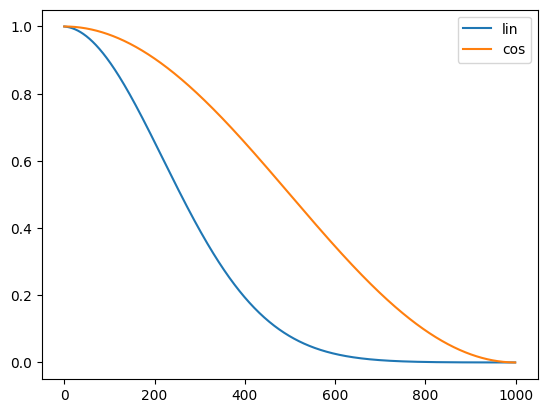

In [ ]:
lin_abar = linear_sched().abar
cos_abar = cos_sched().abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

Here is the plot of the slope of the functions

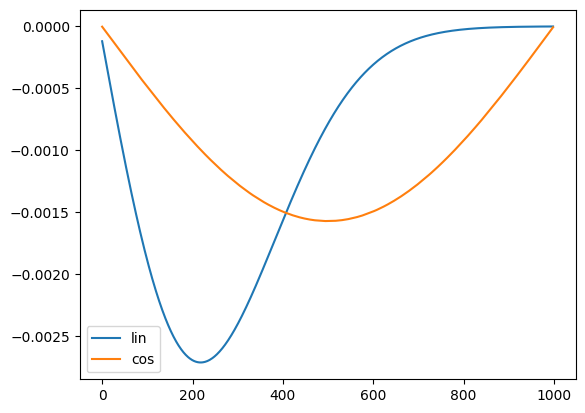

In [ ]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

The interesting things is that we can change `betamax` from 0.2 -> 0.1 and we get a simplar shape to a `Cosine Scheduler`

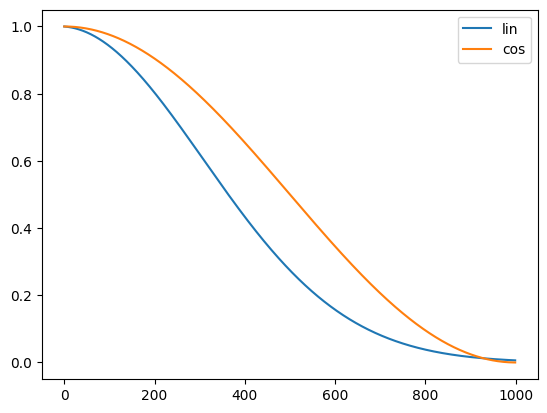

In [ ]:
lin_abar = linear_sched(betamax=0.01).abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

Once again the slopes

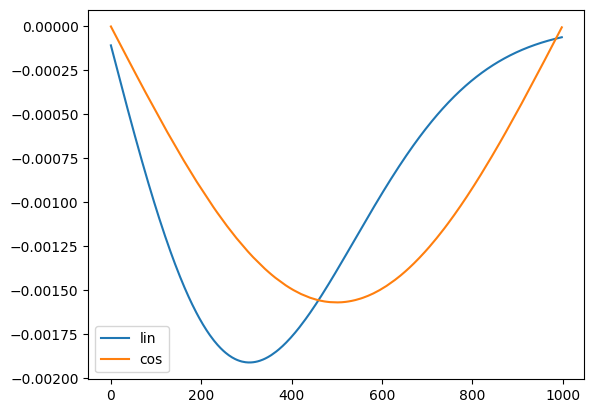

In [ ]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

In [ ]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [ ]:
dt = dls.train
xb,yb = next(iter(dt))

In [ ]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([ 26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572, 315, 295,
        567, 706, 749, 876,  73, 111, 899, 213, 541, 769, 287])

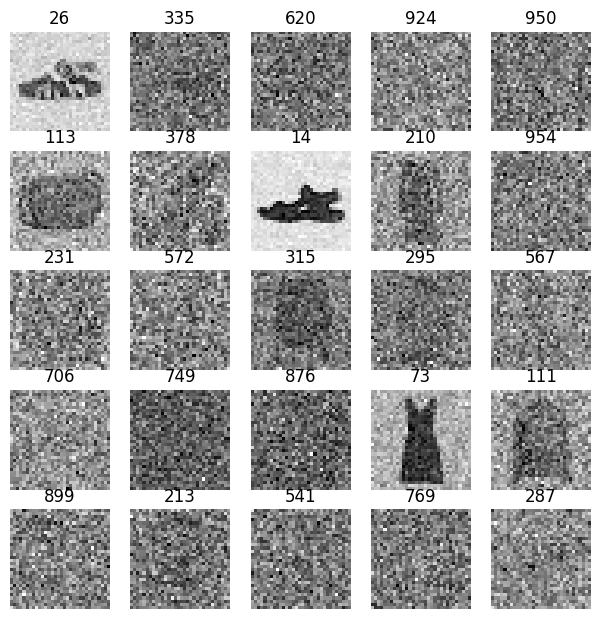

In [ ]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25], imsize=1.5, titles=titles)

## Training

In [ ]:
from diffusers import UNet2DModel

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8).to('cuda')
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.199,0,train
0.041,0,eval
0.035,1,train
0.032,1,eval
0.031,2,train
0.035,2,eval
0.029,3,train
0.028,3,eval
0.028,4,train
0.029,4,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


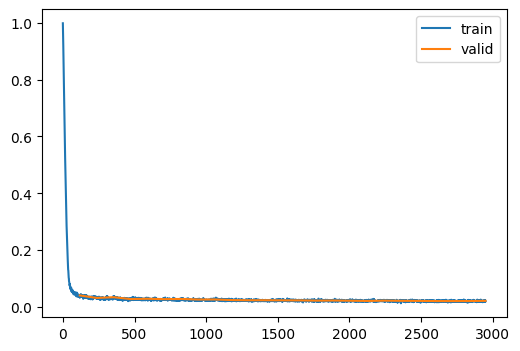

In [ ]:
learn.fit(epochs)

In [ ]:
mdl_path = Path('models')

In [ ]:
torch.save(learn.model, mdl_path/'fashion_ddpm3_25.pkl')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [ ]:
n_samples = 512

In [ ]:
%%time
samples = sample(model, (n_samples, 1, 32, 32))

CPU times: user 6min 8s, sys: 1.45 s, total: 6min 10s
Wall time: 6min 18s


In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)
s.min(),s.max()

(tensor(-1.1063), tensor(1.4101))

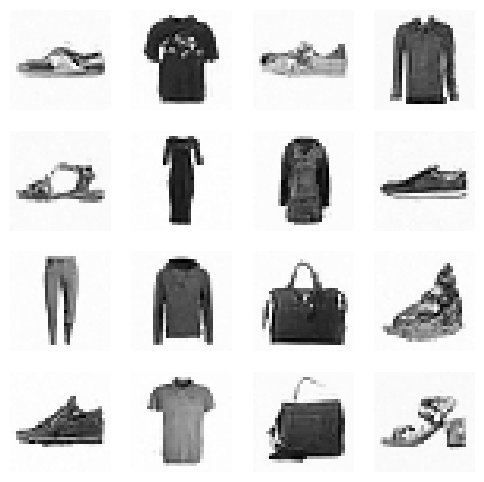

In [ ]:
show_images(s[:16], imsize=1.5)

I have to `clean_mem` to load in different model

In [ ]:
clean_mem()

We load the FashionMnist classifier to calculate `FID`

In [ ]:
@inplace
def transformi2(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds2 = dsd.with_transform(transformi2)
dls2 = DataLoaders.from_dd(tds2, bs, num_workers=fc.defaults.cpus)

# Running on google colab
cmodel = torch.load('drive/MyDrive/data_aug2.pkl',map_location=('cpu')).to('cuda')
#cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [ ]:
from tinyai.fid import ImageEval

In [ ]:
ie = ImageEval(cmodel, dls2, cbs=[DeviceCB()])

Sampling

In [ ]:
ie.fid(s)

12.5863037109375

In [ ]:
s.min(),s.max()

(tensor(-1.1063), tensor(1.4101))

FashionMNIST classifier

In [ ]:
ie.fid(xb*2)

6.007568359375

### Skip sampling

And one again we clean the memory for the model

In [ ]:
clean_mem()
os.environ['CUDA_VISIBLE_DEVICES']='1'
model = torch.load(mdl_path/'fashion_ddpm3_25.pkl',map_location=('cpu')).cuda()

In [ ]:
@torch.no_grad()
def sample_skip(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        # Here we only sample the data every 3rd time making the sampling 3x times faster
        if t%3==0 or t<50: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu().float())
    return preds

In [ ]:
%%time
samples = sample_skip(model, (n_samples, 1, 32, 32))

CPU times: user 2min 16s, sys: 1.34 s, total: 2min 17s
Wall time: 2min 23s


In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)

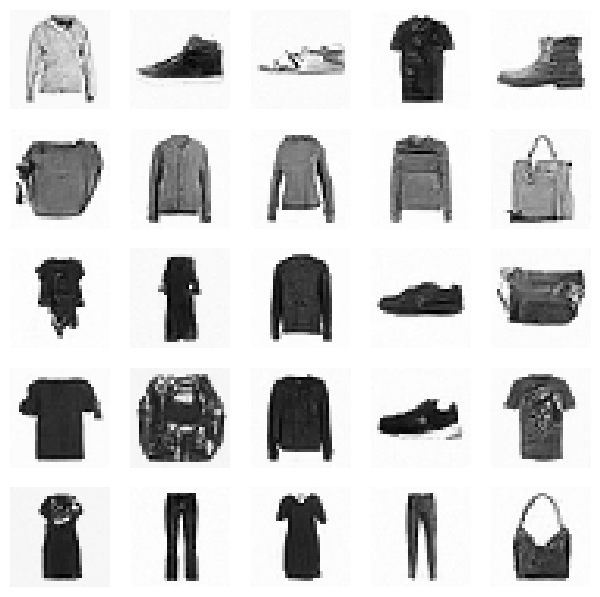

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s)

11.725341796875

In [ ]:
sample_at = [t for t in range(n_steps) if (t+101)%((t+101)//100)==0]
sample_at[:10],sample_at[-10:]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [909, 919, 929, 939, 949, 959, 969, 979, 989, 999])

In [ ]:
@torch.no_grad()
def sample2(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    # Here we sample a lot a the beggining and less the further the models go on
    sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t in sample_at: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        if t in sample_at: preds.append(x_t.float().cpu())
    return preds

In [ ]:
%%time
samples = sample2(model, (n_samples, 1, 32, 32))

CPU times: user 1min 44s, sys: 327 ms, total: 1min 44s
Wall time: 1min 56s


In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)

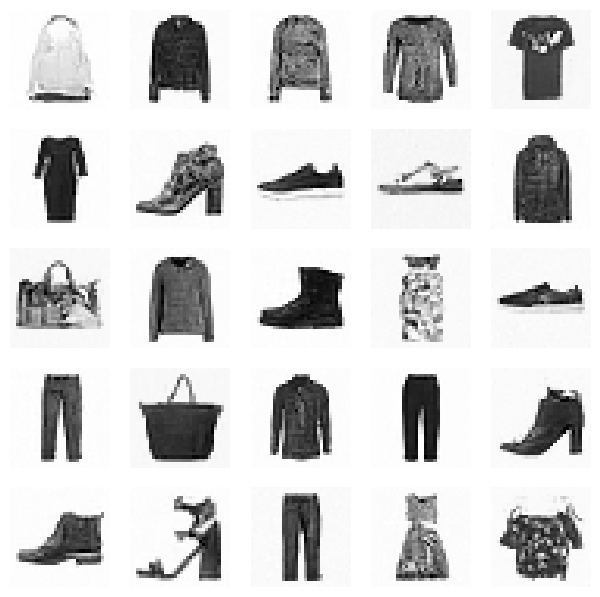

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s)

15.279052734375